In [92]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import sys  

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.plotting import results as results_plot
from soundings.experiments import results as results_calc
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.experiments import neuralnetwork_driver as nndriver
from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_utils
from soundings.preprocessing import dataloader as dl

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    # tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

Thu Jan 28 18:46:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   33C    P8    13W / 260W |     16MiB / 24212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

## Data Loader

In [3]:
f = '/mnt/data1/stock/mlsoundings/preprocessed_alley.npz'
container = np.load(f)
raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files']
container.close()

train_i, val_i, test_i = ml.standard_partition_indicies(sonde_files, percentages=(0.75,0.10,0.15),
                                                        shuffle=True, seed=1234)

RAPtrain,  RAPval,  RAPtest  = rap[train_i], rap[val_i], rap[test_i]
RTMAtrain, RTMAval, RTMAtest = rtma[train_i], rtma[val_i], rtma[test_i]
GOEStrain, GOESval, GOEStest = goes[train_i], goes[val_i], goes[test_i]
RAOBtrain, RAOBval, RAOBtest = raob[train_i], raob[val_i], raob[test_i]
FILEtrain, FILEval, FILEtest = sonde_files[train_i], sonde_files[val_i], sonde_files[test_i]

In [66]:
data = (RAPtrain , RAPval,  RAPtest, 
        RTMAtrain, RTMAval, RTMAtest,
        GOEStrain, GOESval, GOEStest,
        RAOBtrain, RAOBval, RAOBtest)

rap_input_dims = [0, 1, 2, 3]
rap_output_dims = [1, 2]
rtma_input_channels = [0, 1, 2]
goes_input_channels = [0, 1, 2, 3, 4, 5, 6, 7]

driver = nndriver.NeuralNetworkDriver()

Xt, Tt, Xv, Tv, Xe, Te = driver.organize_data(data, rap_input_dims, rap_output_dims,
                                              rtma_input_channels, goes_input_channels)

INFO: data organization - [0, 1, 2, 3] [1, 2] [0, 1, 2] [0, 1, 2, 3, 4, 5, 6, 7]
INFO: data dimensions - (28782, 1123) (28782, 512) (3840, 1123) (3840, 512) (5733, 1123) (5733, 512)


## Baseline Metrics

In [5]:
baseline = dict()

sets = ['train', 'val', 'test']

for i, (RAP, RAOB) in enumerate([(RAPtrain, RAOBtrain),
                                 (RAPval  , RAOBval),
                                 (RAPtest , RAOBtest)]):
    (rmse, mean_rmse, # temperature
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,1], RAOB[:, :, 1])
    baseline[f'rap_temperature_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_temperature_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc
    
    (rmse, mean_rmse, #dewpoint
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,2], RAOB[:, :, 2])
    baseline[f'rap_dewpoint_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_dewpoint_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc

In [6]:
def store_model_results(r, s, Y, T):
    TEMP, DEWPT = 0, 1
    (rmse, mean_rmse,
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Y[:,:,TEMP], T[:, :, 1])
    r[f'ml_temperature_{s}_rmse'] = rmse.tolist()
    r[f'ml_temperature_{s}_mean_rmse'] = mean_rmse
    r[f'ml_temperature_{s}_rmse_sfc'] = rmse_sfc.tolist()
    r[f'ml_temperature_{s}_mean_rmse_sfc'] = mean_rmse_sfc

    (rmse, mean_rmse,
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Y[:,:,DEWPT], T[:, :, 2])
    r[f'ml_dewpoint_{s}_rmse'] = rmse.tolist()
    r[f'ml_dewpoint_{s}_mean_rmse'] = mean_rmse
    r[f'ml_dewpoint_{s}_rmse_sfc'] = rmse_sfc.tolist()
    r[f'ml_dewpoint_{s}_mean_rmse_sfc'] = mean_rmse_sfc

## Linear Model

In [67]:
linear_r = dict()

n_network_inputs = Xt.shape[1]
n_network_outputs = Tt.shape[1]

n_epochs = 500
batch_size = 128
lr = 0.0001
optim = 'adam'
loss = 'MAE'

linear_nnet = nn.NeuralNetwork(n_network_inputs, [0], n_network_outputs)
linear_nnet.model.summary()

linear_nnet.train(Xt, Tt, n_epochs, batch_size, method=optim, verbose=False,
                  learning_rate=lr, validation=(Xv, Tv), loss_f=loss)

print(f'INFO: finished training model in {linear_nnet.training_time:.3f} seconds. Benchmarking now.')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1123)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               575488    
Total params: 575,488
Trainable params: 575,488
Non-trainable params: 0
_________________________________________________________________
INFO: finished training model in 162.632 seconds. Benchmarking now.


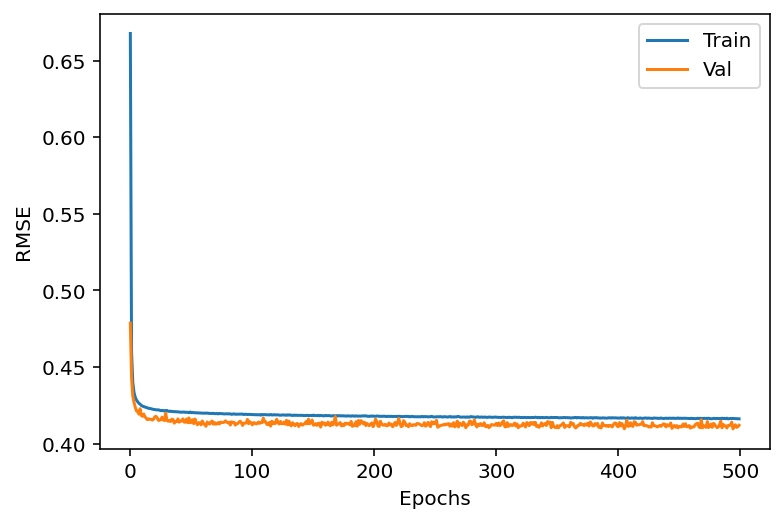

In [68]:
linear_r['root_mean_squared_error'] = linear_nnet.history['root_mean_squared_error']
linear_r['val_root_mean_squared_error'] = linear_nnet.history['val_root_mean_squared_error']

fig, ax = plt.subplots()
ax.plot(linear_r['root_mean_squared_error'])
ax.plot(linear_r['val_root_mean_squared_error'])
ax.set_xlabel('Epochs'); ax.set_ylabel('RMSE')
ax.legend(['Train', 'Val']);

In [69]:
sets = ['train', 'val', 'test']
for j, (X, RAP, T) in enumerate([(Xt, RAPtrain, RAOBtrain),
                                 (Xv, RAPval  , RAOBval),
                                 (Xe, RAPtest , RAOBtest)]):
    Y = linear_nnet.use(X).reshape(RAP[:,:,rap_output_dims].shape)
    store_model_results(linear_r, sets[j], Y, T)

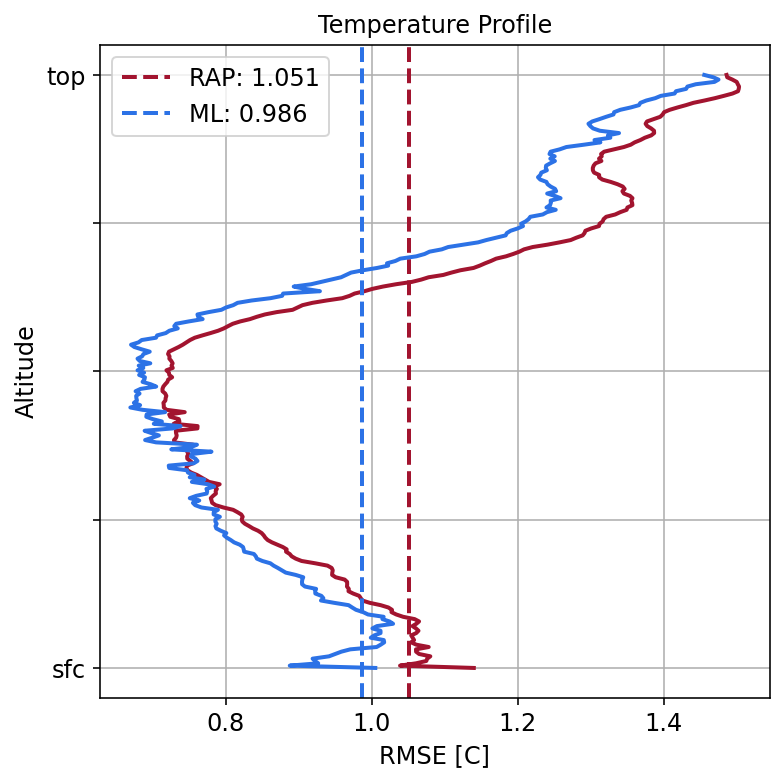

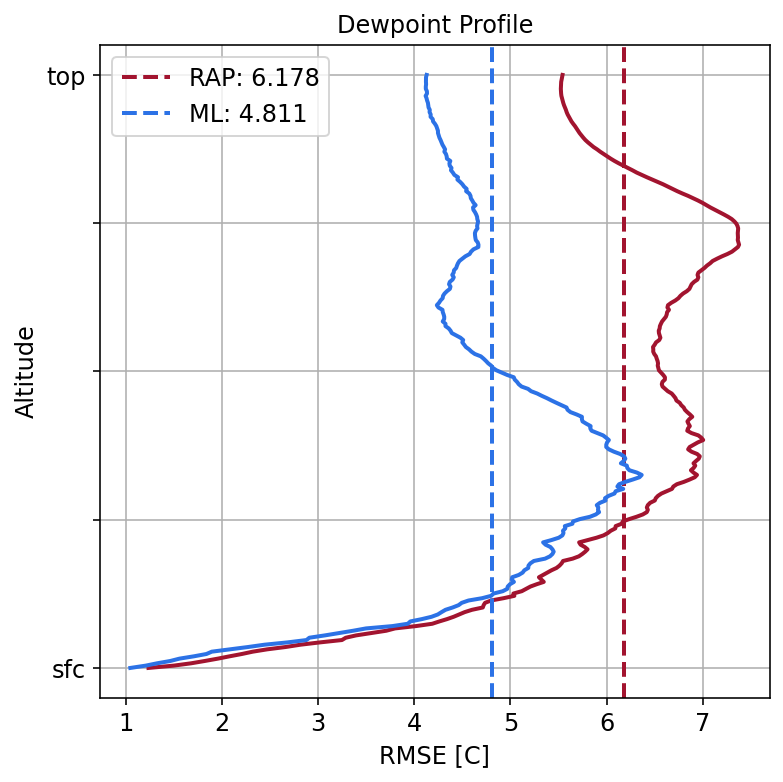

In [70]:
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(linear_r[f'ml_{v}_test_rmse'])
    ml_mean_rmse = np.asarray(linear_r[f'ml_{v}_test_mean_rmse'])
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse,
                                               title=f'{v.capitalize()} Profile')

## Fully Connected #1

In [71]:
Tt -= linear_nnet.use(Xt)
Tv -= linear_nnet.use(Xv)
Te -= linear_nnet.use(Xe)

In [72]:
fc_nnet_1_r = dict()

n_network_inputs = Xt.shape[1]
n_network_outputs = Tt.shape[1]

n_epochs = 300
batch_size = 128
lr = 0.0001
optim = 'adam'
loss = 'MAE'

activ = 'relu'
dropout = False
batchnorm = False

fc_nnet_1 = nn.NeuralNetwork(n_network_inputs, [8], n_network_outputs, activation=activ,
                             dropout=dropout, batchnorm=batchnorm)
fc_nnet_1.model.summary()

fc_nnet_1.train(Xt, Tt, n_epochs, batch_size, method=optim, verbose=False,
                learning_rate=lr, validation=(Xv, Tv), loss_f=loss)

print(f'INFO: finished training model in {fc_nnet_1.training_time:.3f} seconds. Benchmarking now.')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1123)]            0         
_________________________________________________________________
dense (Dense)                (None, 8)                 8992      
_________________________________________________________________
activation (Activation)      (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4608      
Total params: 13,600
Trainable params: 13,600
Non-trainable params: 0
_________________________________________________________________
INFO: finished training model in 109.454 seconds. Benchmarking now.


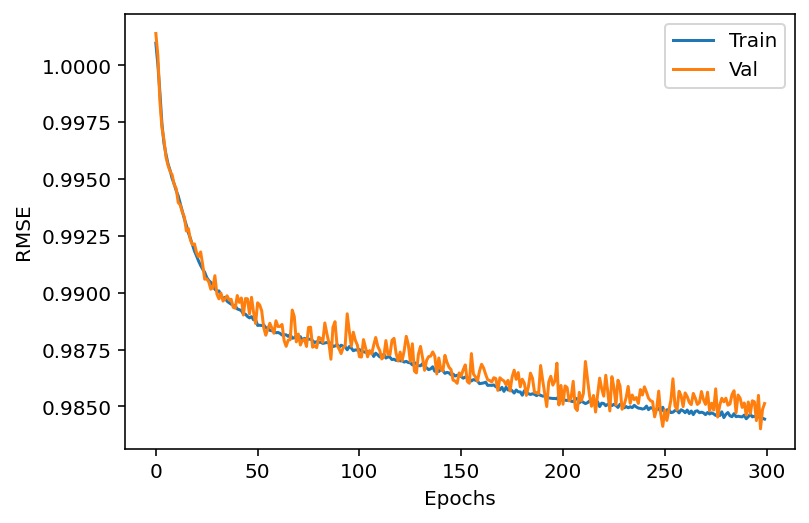

In [73]:
fc_nnet_1_r['root_mean_squared_error'] = fc_nnet_1.history['root_mean_squared_error']
fc_nnet_1_r['val_root_mean_squared_error'] = fc_nnet_1.history['val_root_mean_squared_error']

fig, ax = plt.subplots()
ax.plot(fc_nnet_1_r['root_mean_squared_error'])
ax.plot(fc_nnet_1_r['val_root_mean_squared_error'])
ax.set_xlabel('Epochs'); ax.set_ylabel('RMSE')
ax.legend(['Train', 'Val']);

In [74]:
sets = ['train', 'val', 'test']
for j, (X, RAP, T) in enumerate([(Xt, RAPtrain, RAOBtrain),
                                 (Xv, RAPval  , RAOBval),
                                 (Xe, RAPtest , RAOBtest)]):
    Y = fc_nnet_1.use(X) + linear_nnet.use(X)
    Y = Y.reshape(RAP[:,:,rap_output_dims].shape)
    store_model_results(fc_nnet_1_r, sets[j], Y, T)

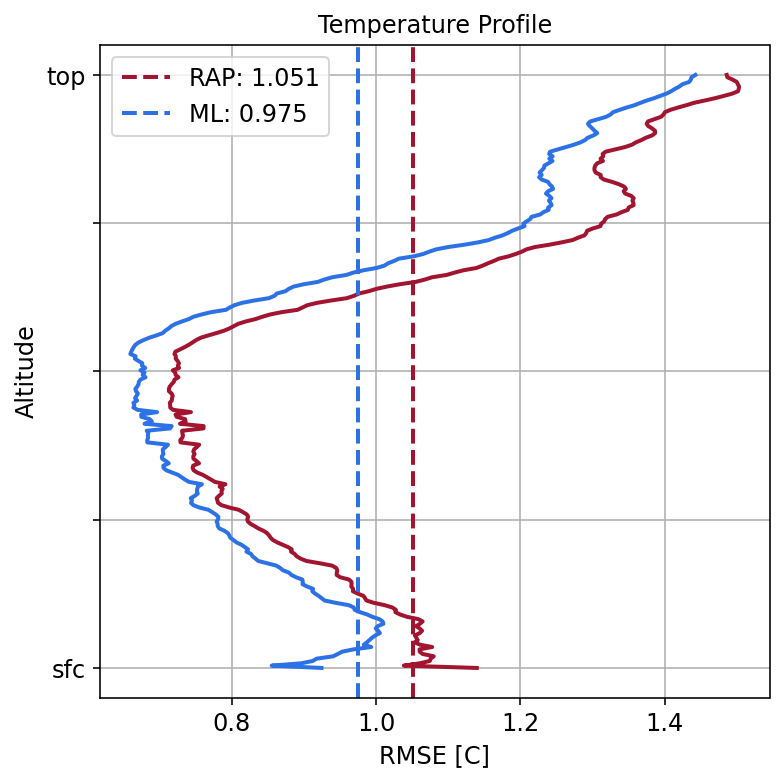

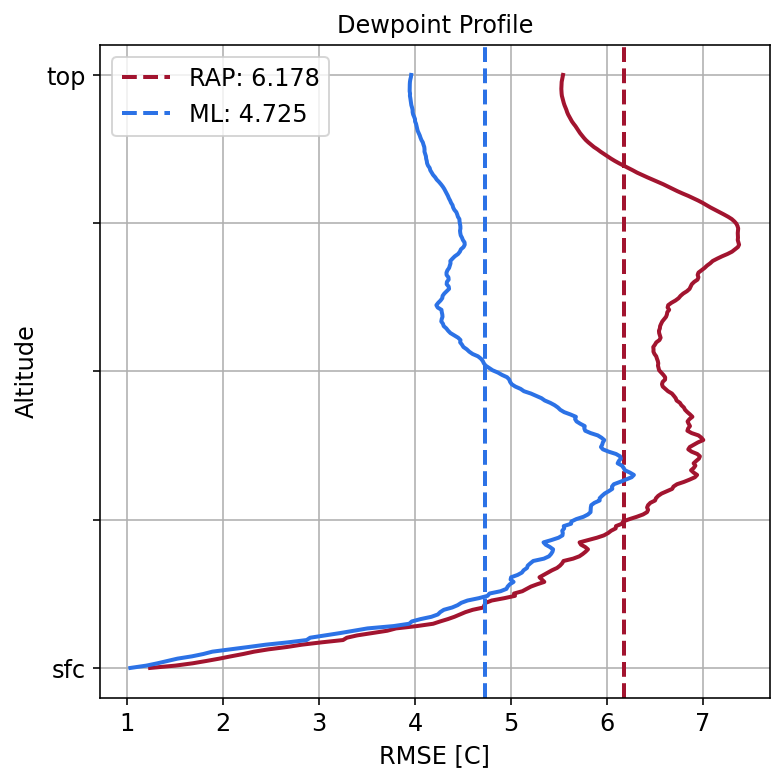

In [75]:
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(fc_nnet_1_r[f'ml_{v}_test_rmse'])
    ml_mean_rmse = np.asarray(fc_nnet_1_r[f'ml_{v}_test_mean_rmse'])
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse,
                                               title=f'{v.capitalize()} Profile')

## Fully Connected #2

In [76]:
Tt -= fc_nnet_1.use(Xt)
Tv -= fc_nnet_1.use(Xv)
Te -= fc_nnet_1.use(Xe)

In [77]:
fc_nnet_2_r = dict()

n_network_inputs = Xt.shape[1]
n_network_outputs = Tt.shape[1]

n_epochs = 200
batch_size = 128
lr = 0.0001
optim = 'adam'
loss = 'MAE'

activ = 'relu'
dropout = False
batchnorm = False

fc_nnet_2 = nn.NeuralNetwork(n_network_inputs, [16, 32], n_network_outputs, activation=activ,
                             dropout=dropout, batchnorm=batchnorm)
fc_nnet_2.model.summary()

fc_nnet_2.train(Xt, Tt, n_epochs, batch_size, method=optim, verbose=False,
                learning_rate=lr, validation=(Xv, Tv), loss_f=loss)

print(f'INFO: finished training model in {fc_nnet_2.training_time:.3f} seconds. Benchmarking now.')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1123)]            0         
_________________________________________________________________
dense (Dense)                (None, 16)                17984     
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               16896     
Total params: 35,424
Trainable params: 35,424
Non-trainable params: 0
__________________________________________________

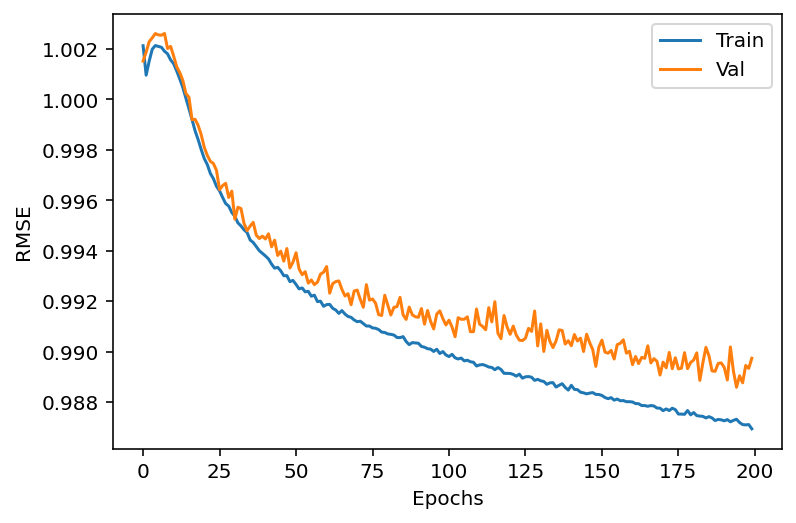

In [78]:
fc_nnet_2_r['root_mean_squared_error'] = fc_nnet_2.history['root_mean_squared_error']
fc_nnet_2_r['val_root_mean_squared_error'] = fc_nnet_2.history['val_root_mean_squared_error']

fig, ax = plt.subplots()
ax.plot(fc_nnet_2_r['root_mean_squared_error'])
ax.plot(fc_nnet_2_r['val_root_mean_squared_error'])
ax.set_xlabel('Epochs'); ax.set_ylabel('RMSE')
ax.legend(['Train', 'Val']);

In [79]:
sets = ['train', 'val', 'test']
for j, (X, RAP, T) in enumerate([(Xt, RAPtrain, RAOBtrain),
                                 (Xv, RAPval  , RAOBval),
                                 (Xe, RAPtest , RAOBtest)]):
    Y = fc_nnet_2.use(X) + fc_nnet_1.use(X) + linear_nnet.use(X)
    Y = Y.reshape(RAP[:,:,rap_output_dims].shape)
    store_model_results(fc_nnet_2_r, sets[j], Y, T)

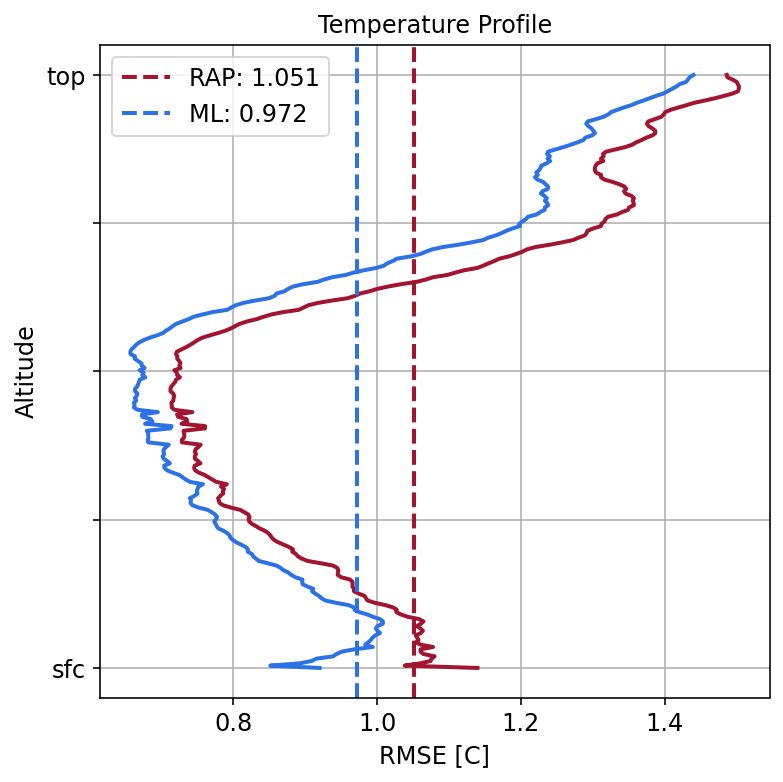

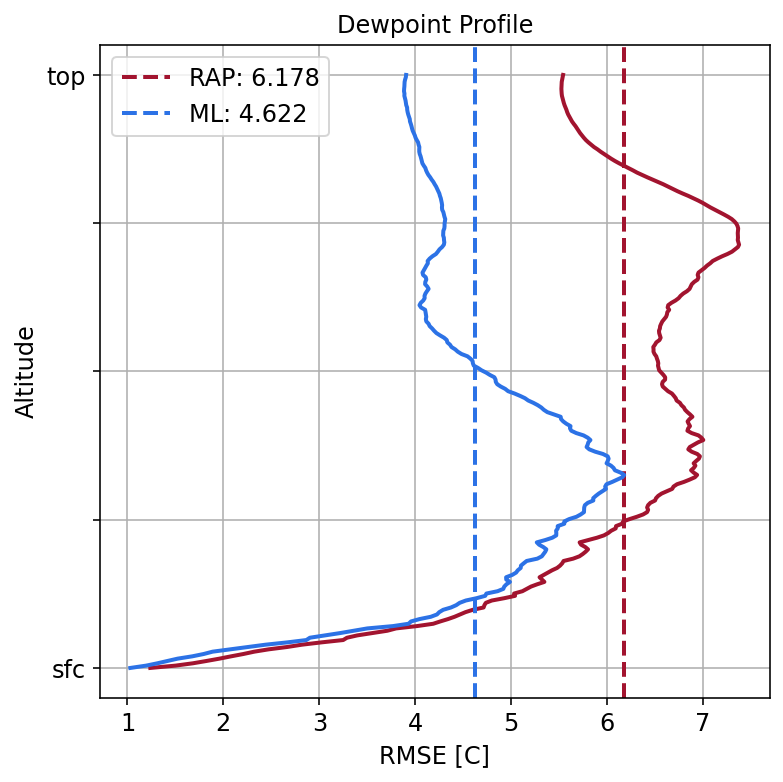

In [80]:
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(fc_nnet_2_r[f'ml_{v}_test_rmse'])
    ml_mean_rmse = np.asarray(fc_nnet_2_r[f'ml_{v}_test_mean_rmse'])
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse,
                                               title=f'{v.capitalize()} Profile')

## Fully Connected #3

In [81]:
Tt -= fc_nnet_2.use(Xt)
Tv -= fc_nnet_2.use(Xv)
Te -= fc_nnet_2.use(Xe)

In [86]:
fc_nnet_3_r = dict()

n_network_inputs = Xt.shape[1]
n_network_outputs = Tt.shape[1]

n_epochs = 200
batch_size = 128
lr = 0.0001
optim = 'adam'
loss = 'MAE'

activ = 'relu'
dropout = False
batchnorm = False

fc_nnet_3 = nn.NeuralNetwork(n_network_inputs, [128], n_network_outputs, activation=activ,
                             dropout=dropout, batchnorm=batchnorm)
fc_nnet_3.model.summary()

fc_nnet_3.train(Xt, Tt, n_epochs, batch_size, method=optim, verbose=False,
                learning_rate=lr, validation=(Xv, Tv), loss_f=loss)

print(f'INFO: finished training model in {fc_nnet_3.training_time:.3f} seconds. Benchmarking now.')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1123)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               143872    
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               66048     
Total params: 209,920
Trainable params: 209,920
Non-trainable params: 0
_________________________________________________________________
INFO: finished training model in 72.644 seconds. Benchmarking now.


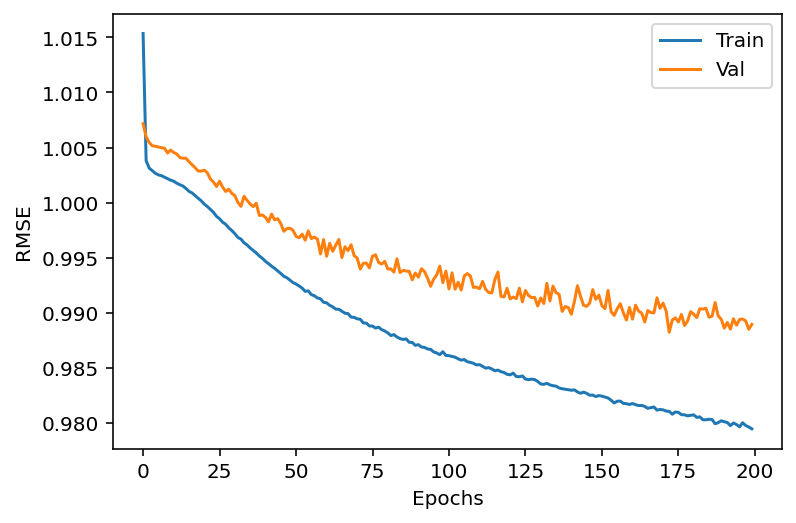

In [87]:
fc_nnet_3_r['root_mean_squared_error'] = fc_nnet_3.history['root_mean_squared_error']
fc_nnet_3_r['val_root_mean_squared_error'] = fc_nnet_3.history['val_root_mean_squared_error']

fig, ax = plt.subplots()
ax.plot(fc_nnet_3_r['root_mean_squared_error'])
ax.plot(fc_nnet_3_r['val_root_mean_squared_error'])
ax.set_xlabel('Epochs'); ax.set_ylabel('RMSE')
ax.legend(['Train', 'Val']);

In [88]:
sets = ['train', 'val', 'test']
for j, (X, RAP, T) in enumerate([(Xt, RAPtrain, RAOBtrain),
                                 (Xv, RAPval  , RAOBval),
                                 (Xe, RAPtest , RAOBtest)]):
    Y = fc_nnet_3.use(X) + fc_nnet_2.use(X) + fc_nnet_1.use(X) + linear_nnet.use(X)
    Y = Y.reshape(RAP[:,:,rap_output_dims].shape)
    store_model_results(fc_nnet_3_r, sets[j], Y, T)

In [153]:
np.asarray(fc_nnet_3_r[f'ml_temperature_test_rmse'])[0]

0.9172876312904169

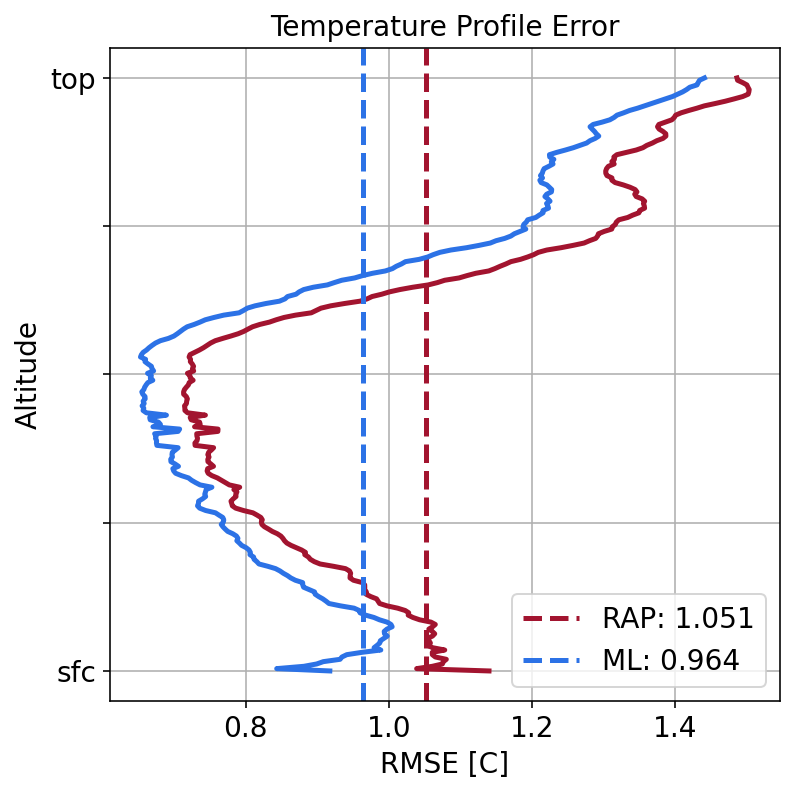

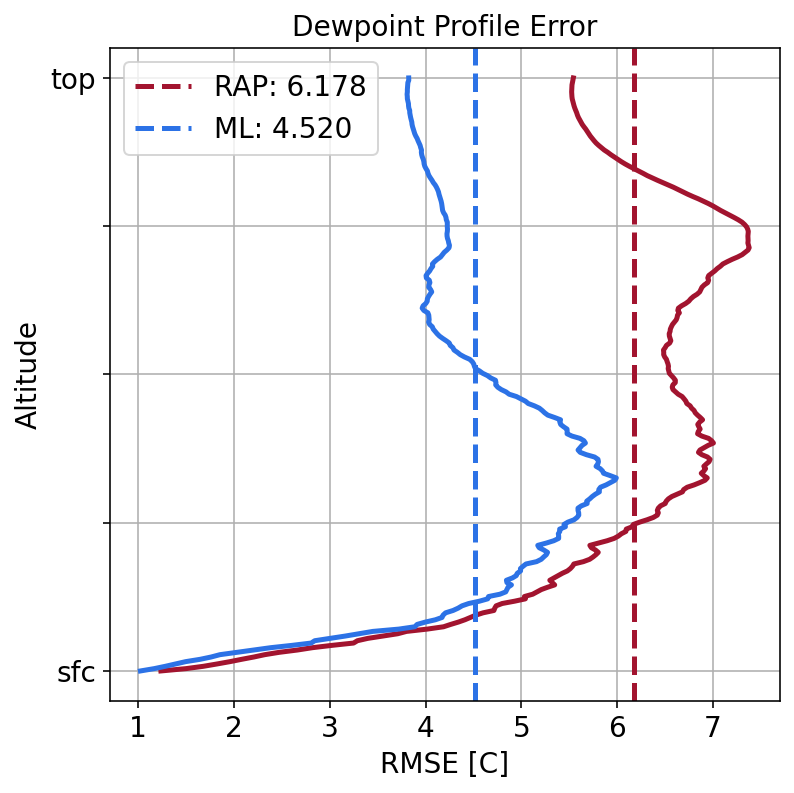

In [157]:
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(fc_nnet_3_r[f'ml_{v}_test_rmse'])
    ml_mean_rmse = np.asarray(fc_nnet_3_r[f'ml_{v}_test_mean_rmse'])
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse,
                                               title=f'{v.capitalize()} Profile Error',
                                               file_name=f'/home/stock/research/media/cascading_{v}_all_data.pdf')

## Profile Examples

In [118]:
np.argsort(-abs(RAOBtest - RAPtest)[:,0,dl.TEMPERATURE])[10:20]

array([5648, 1273, 2623, 2233, 5350, 1572,  486,   81,  907, 1126])

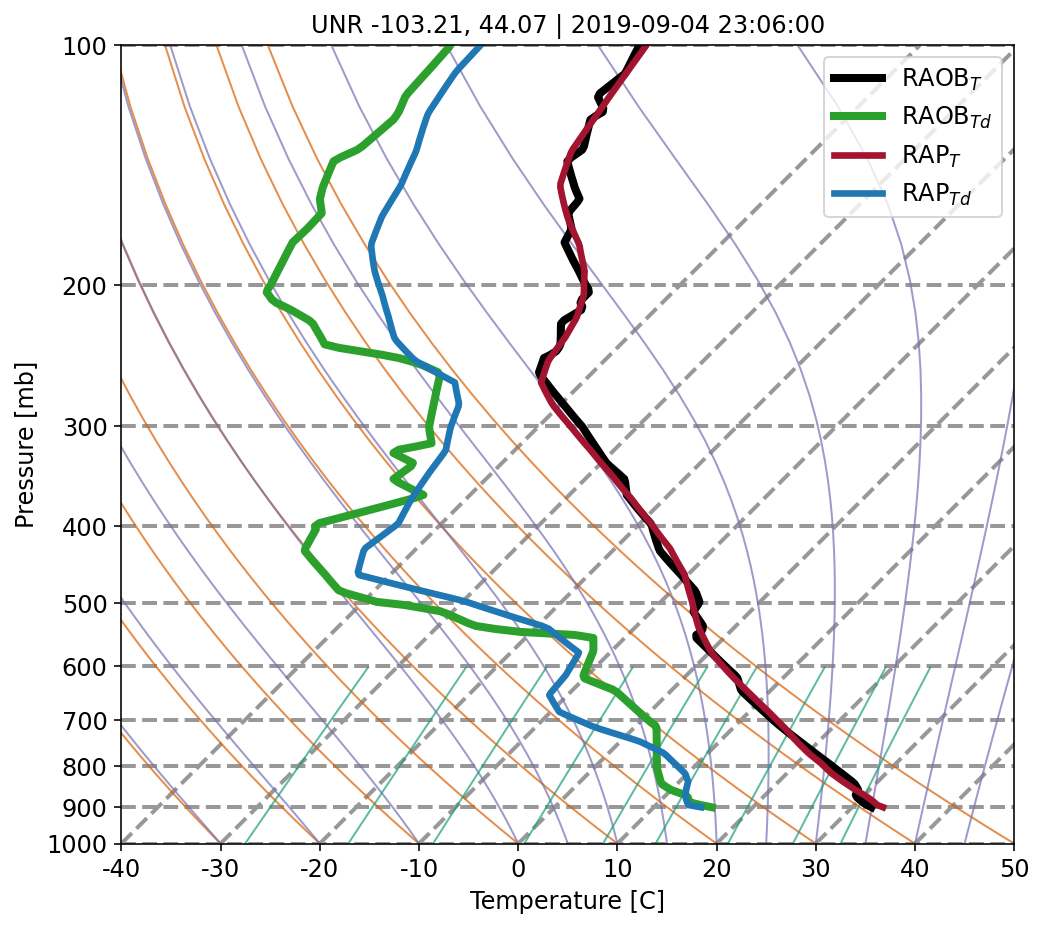

In [146]:
index = 1 # 1126
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtest[index,:,dl.PRESSURE]

sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtest[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtest[index,:,dl.TEMPERATURE]

sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = RAOBtest[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = RAPtest[index,:,dl.DEWPOINT]

content = FILEtest[index].split('_')
date = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f')
lon, lat = content[-2], content[-1]
title = f'{content[0].upper()} {lon}, {lat} | {date}'
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title); #, file_name=f"/home/stock/research/media/{content[0]}-{content[1]}-rapvraob.pdf");

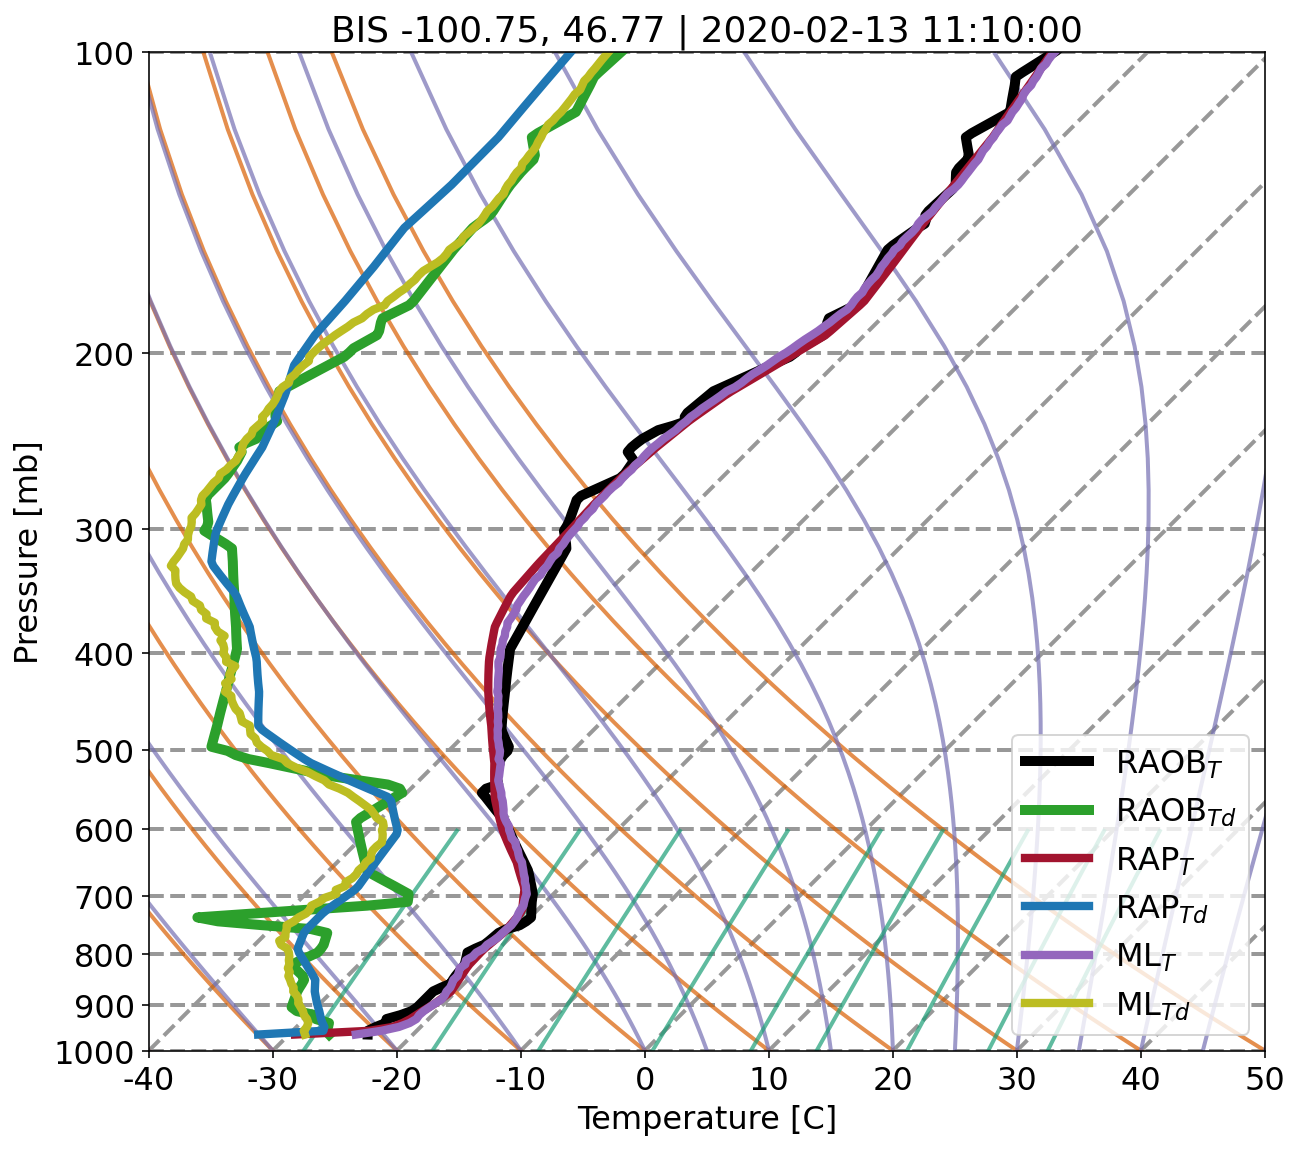

In [156]:
index = 1126 # 1

X = Xe[index:index+1]
Y = fc_nnet_3.use(X) + fc_nnet_2.use(X) + fc_nnet_1.use(X) + linear_nnet.use(X)
Y = Y.reshape(RAPtest[0:1,:,rap_output_dims].shape)

sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtest[index,:,dl.PRESSURE]

sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtest[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtest[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = Y[0,:,0]

sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = RAOBtest[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = RAPtest[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.PREDICTED_DEWPOINT_COLUMN_KEY] = Y[0,:,1]

content = FILEtest[index].split('_')
date = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f')
lon, lat = content[-2], content[-1]
title = f'{content[0].upper()} {lon}, {lat} | {date}'
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title,
                                         file_name=f"/home/stock/research/media/{content[0]}-{content[1]}_cascade_surface.pdf");

In [159]:
RAOBtest[index,0,dl.TEMPERATURE],RAPtest[index,0,dl.TEMPERATURE],Y[0,0,0]

(-23.649993896484375, -29.512999999999977, -24.608035059375215)

In [160]:
RAOBtest[index,0,dl.DEWPOINT],RAPtest[index,0,dl.DEWPOINT],Y[0,0,1]

(-26.75, -32.48562966192634, -28.71149758747643)